## This notebook shows how to create datasets for DTMicroscope(STEM)

In [1]:
import numpy as np
import sidpy
import pyNSID
import h5py
import SciFiReaders

### 1. Download the raw dataset

In [3]:
# Download a file
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()


In [5]:
loadedfile.keys()

dict_keys(['image', 'spectrum image', 'energy axis', 'scale'])

### 2. Based on the dataset initialize the relevant variables

In [8]:
image = loadedfile['image']
spectrum_image = loadedfile['spectrum image']
energy_axis = loadedfile['energy axis']
scale = loadedfile['scale']

In [37]:
energy_axis

array([0.20024911, 0.20087216, 0.20149521, ..., 1.13046241, 1.13108546,
       1.13170851])

#### 2.a Set channels and types

In [33]:
data_sets = {'Channel_000': sidpy.Dataset.from_array(image, name = "overview image"),
             'Channel_001': sidpy.Dataset.from_array(spectrum_image, name = "spectrum image")}

In [36]:
data_sets['Channel_000'].data_type = 'image'
data_sets['Channel_001'].data_type = 'spectral_image'


# data_set.dimension_type = 

In [39]:
data_sets['Channel_000'].set_dimension(0, sidpy.Dimension(np.arange(data_sets['Channel_001'].shape[0])*scale, 
                                          name='x', units='nm', quantity='Length',
                                          dimension_type='spatial'))

data_sets['Channel_000'].set_dimension(1, sidpy.Dimension(np.arange(data_sets['Channel_001'].shape[1])*scale,
                                          'y', units='nm', quantity='Length',
                                          dimension_type='spatial'))
data_sets['Channel_001'].set_dimension(0, sidpy.Dimension(np.arange(data_sets['Channel_001'].shape[0])*scale, 
                                          name='x', units='nm', quantity='Length',
                                          dimension_type='spatial'))
data_sets['Channel_001'].set_dimension(1, sidpy.Dimension(np.arange(data_sets['Channel_001'].shape[1])*scale,
                                          'y', units='nm', quantity='Length',
                                          dimension_type='spatial'))
data_sets['Channel_001'].set_dimension(2, sidpy.Dimension(energy_axis,
                                          'energy_scale', units='eV', quantity='Energy',
                                          dimension_type='spectral'))


#### 2b. set metadata

In [57]:
data_sets['Channel_000'].metadata['blah'] = 'blah'


{'blah': 'blah'}

### 3. Save to disk as h5py dataset

In [42]:
def save_dataset_dictionary(h5_file, datasets):
    h5_measurement_group = sidpy.hdf.prov_utils.create_indexed_group(h5_file, 'Measurement_')
    for key, dataset in datasets.items():
        if key[-1] == '/':
            key = key[:-1]
        if isinstance(dataset, sidpy.Dataset):
            h5_group = h5_measurement_group.create_group(key)
            h5_dataset = pyNSID.hdf_io.write_nsid_dataset(dataset, h5_group)
            dataset.h5_dataset = h5_dataset
            h5_dataset.file.flush()
        elif isinstance(dataset, dict):
            sidpy.hdf.hdf_utils.write_dict_to_h5_group(h5_measurement_group, dataset, key)
        else:
            print('could not save item ', key, 'of dataset dictionary')
    return h5_measurement_group

In [46]:
dataset_name = 'test.h5'
h5_file = h5py.File(dataset_name, mode='a')
save_dataset_dictionary(h5_file, data_sets)

/Users/utkarshpratiush/opt/anaconda3/envs/gerd_course/lib/python3.10/site-packages/pyNSID/io/hdf_utils.py:381: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
/Users/utkarshpratiush/opt/anaconda3/envs/gerd_course/lib/python3.10/site-packages/pyNSID/io/hdf_utils.py:381: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


<HDF5 group "/Measurement_000" (2 members)>

In [47]:
h5_file.close()

### 4. Lets read it to verify

In [49]:
reader = SciFiReaders.NSIDReader("test.h5")
datasets = reader.read()

In [58]:
datasets

[sidpy.Dataset of type IMAGE with:
  dask.array<array, shape=(62, 75), dtype=float64, chunksize=(62, 75), chunktype=numpy.ndarray>
  data contains: generic (generic)
  and Dimensions: 
 x:  Length (nm) of size (62,)
 y:  Length (nm) of size (75,),
 sidpy.Dataset of type SPECTRAL_IMAGE with:
  dask.array<array, shape=(62, 75, 1496), dtype=float64, chunksize=(62, 75, 1496), chunktype=numpy.ndarray>
  data contains: generic (generic)
  and Dimensions: 
 x:  Length (nm) of size (62,)
 y:  Length (nm) of size (75,)
 energy_scale:  Energy (eV) of size (1496,)]

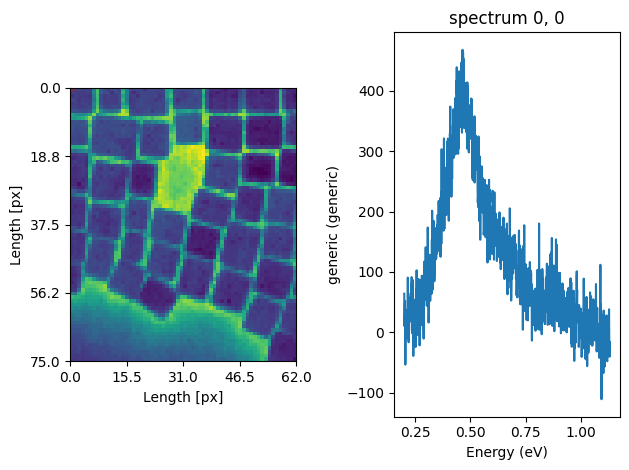

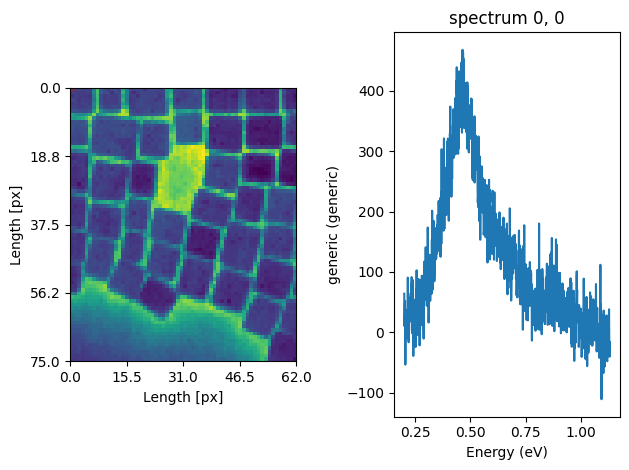

In [61]:
# datasets[1].plot()